In [1]:
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)
promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [4]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

In [5]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [6]:
# LacI binding site
rep_site = 'AATTGTGAGCGGATAACAATT'

In [7]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [8]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Repressor binds much more strongly than RNAP

In [9]:
n_NS = len(genome)
n_p = 3000
n_r = 10
ep_wt = -5

l_er_wt = np.arange(-20, 0, 1)

signal_rnap = []
signal_rep = []
for er_wt in l_er_wt:
    rnap = []
    rep = []
    for i in range(10):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)
        nbins = 2

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-30+116)]) + np.mean(footprint[(-15+115):(-5+116)]))/2)
        rep.append(np.mean(footprint[(2+115):(17+116)]))
    signal_rnap.append(np.mean(rnap))
    signal_rep.append(np.mean(rep))

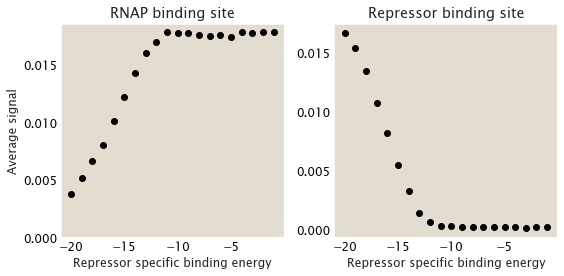

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_er_wt, signal_rnap, color='k')
ax1.set_xlabel('Repressor specific binding energy')
ax1.set_ylabel('Average signal')
ax1.set_title('RNAP binding site')
ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_er_wt, signal_rep, color='k')
ax2.set_xlabel('Repressor specific binding energy')
ax2.set_title('Repressor binding site')
ax2.set_yticks([0, 0.005, 0.01, 0.015])

plt.tight_layout()
plt.savefig('../../figs/relative_binding_energy.png', dpi=300)

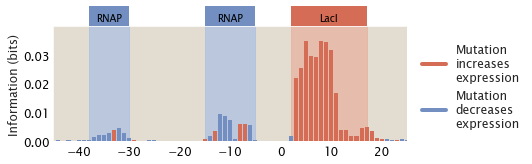

In [16]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -20

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        scaling_factor=10**7)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/bindingenergy3.png')

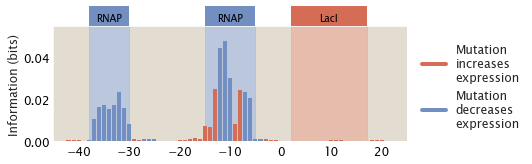

In [12]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        scaling_factor=10**7)

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../figs/bindingenergy4.png')

### RNAP binds much more strongly than activator

In [11]:
# CRP binding site
crp_site = 'ATTAATGTGAGTTAGCTCACTCATTA'

In [12]:
# energy matrix obtained from Fig 3. of Kinney et al., 2010 (https://www.pnas.org/doi/full/10.1073/pnas.1004290107)
# elements expressed in kcal/mol (1 kcal/mol = 1.62kbT)

crp_emat_raw = pd.read_table('../../data/energy_matrices/crp_tau_final_all_26.txt', delim_whitespace=True)
crp_emat = crp_emat_raw[['par_A', 'par_C', 'par_G', 'par_T']].to_numpy().T * 1.62

In [13]:
n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -10
e_ap = -8

l_ea_wt = np.arange(-20, 0, 1)
rnap_signal2 = []
crp_signal = []

for ea_wt in l_ea_wt:
    rnap = []
    crp = []
    for i in range(10):
        df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-29+115)]) + np.mean(footprint[(-15+115):(-4+115)]))/2)
        crp.append(np.mean(footprint[(-70+115):(-52+115)]))
    rnap_signal2.append(np.mean(rnap))
    crp_signal.append(np.mean(crp))

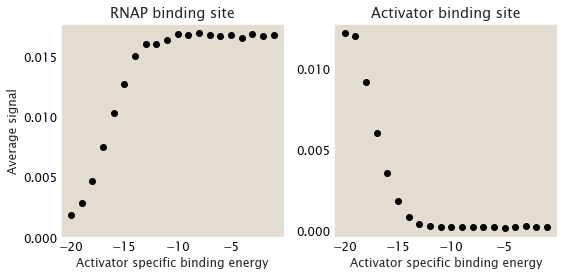

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_ea_wt, rnap_signal2, color='k')
ax1.set_xlabel('Activator specific binding energy')
ax1.set_ylabel('Average signal')
ax1.set_title('RNAP binding site')
ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_ea_wt, crp_signal, color='k')
ax2.set_xlabel('Activator specific binding energy')
ax2.set_title('Activator binding site')
ax2.set_yticks([0, 0.005, 0.01])

plt.tight_layout()
plt.savefig('../../figs/relative_binding_energy2.png', dpi=300)

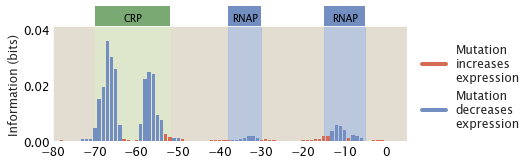

In [25]:
## scaling down all the energy terms

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -10
ea_wt = -20
e_ap = -8

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../manuscript/figures/plots/fig12/simact_1.png')

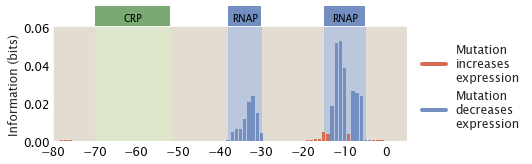

In [26]:
n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -10
ea_wt = -10
e_ap = -8

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../manuscript/figures/plots/fig12/simact_2.png')

### Tuning the interaction energy between RNAP and activator

In [22]:
n_NS = len(genome)
n_p = 4600
n_r = 50
ep_wt = -10
ea_wt = -12

l_e_ap = np.arange(-20, 0, 1)

rnap_signal3 = []
crp_signal2 = []

for e_ap in l_e_ap:
    rnap = []
    crp = []
    for i in range(10):
        df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        nbins = 2
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                    pseudocount=10**(-6))
        rnap.append((np.mean(footprint[(-38+115):(-29+115)]) + np.mean(footprint[(-15+115):(-4+115)]))/2)
        crp.append(np.mean(footprint[(-70+115):(-52+115)]))
    rnap_signal3.append(np.mean(rnap))
    crp_signal2.append(np.mean(crp))

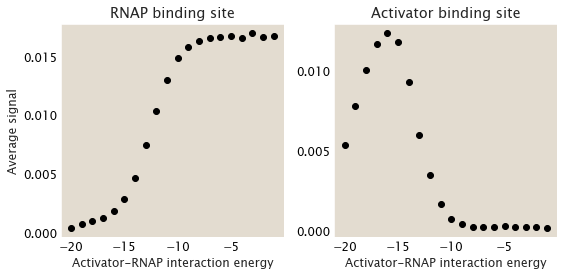

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1, ax2 = axes
ax1.scatter(l_ea_wt, rnap_signal3, color='k')
ax1.set_xlabel('Activator-RNAP interaction energy')
ax1.set_ylabel('Average signal')
ax1.set_title('RNAP binding site')
ax1.set_yticks([0, 0.005, 0.01, 0.015])

ax2.scatter(l_ea_wt, crp_signal2, color='k')
ax2.set_xlabel('Activator-RNAP interaction energy')
ax2.set_title('Activator binding site')
ax2.set_yticks([0, 0.005, 0.01])

plt.tight_layout()
plt.savefig('../../figs/relative_binding_energy3.png', dpi=300)

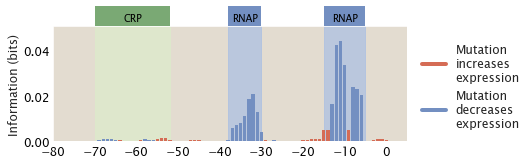

In [27]:
# only increasing strength of RNAP-activator binding

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -10
ea_wt = -12
e_ap = -10

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../manuscript/figures/plots/fig12/simact_3.png')

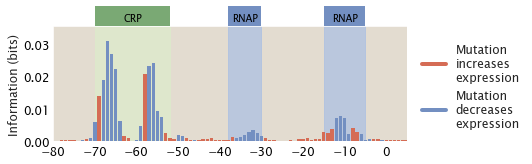

In [29]:
# only increasing strength of RNAP-activator binding

n_NS = len(genome)
n_p = 4600
n_a = 50
ep_wt = -10
ea_wt = -12
e_ap = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simact_pbound, [rnap_site, crp_site], 
                        *[n_NS, n_p, n_a, rnap_emat, crp_emat, ep_wt, ea_wt, e_ap])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (-70, -52, 'A', 'CRP')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-80, 5), fig_width=8,
                               legend_xcoord=1.35,
                               annotate_stn=False,
                               outfile='../../manuscript/figures/plots/fig12/simact_4.png')